In [128]:
# These are the starter packages for EDA and predictive modeling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


Business Questions:
We would like you to use this data set to help understand what factors are best at predicting whether a signup will start to drive, and offer suggestions to operationalize those insights to help Uber.

See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. Please also call out any data related assumptions or issues that you encounter.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip?
2. Build a predictive model to help Uber determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Uber might leverage the insights gained from the model to generate more first trips (again, a few ideas/sentences will suffice).

In [129]:
data = pd.read_csv('/Users/rosiebai/Downloads/datasets/ds_challenge_v2_1_data.csv')

In [130]:
data.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


In [131]:
data.columns

Index(['id', 'city_name', 'signup_os', 'signup_channel', 'signup_date',
       'bgc_date', 'vehicle_added_date', 'vehicle_make', 'vehicle_model',
       'vehicle_year', 'first_completed_date'],
      dtype='object')

## Exploratory Data Analysis

### checking the missing values per column

In [132]:
# check the missing values per column
data.isnull().sum()

id                          0
city_name                   0
signup_os                6857
signup_channel              0
signup_date                 0
bgc_date                21785
vehicle_added_date      41547
vehicle_make            41458
vehicle_model           41458
vehicle_year            41458
first_completed_date    48544
dtype: int64

### checking the value count/pct of categorical variables

In [133]:
data.groupby('city_name')['signup_date'].count()

city_name
Berton     20117
Strark     29557
Wrouver     5007
Name: signup_date, dtype: int64

In [134]:
data.city_name.value_counts(normalize=True)

Strark     0.540535
Berton     0.367897
Wrouver    0.091567
Name: city_name, dtype: float64

In [135]:
data.groupby('signup_channel')['signup_date'].count()

signup_channel
Organic     13427
Paid        23938
Referral    17316
Name: signup_date, dtype: int64

In [136]:
data.signup_channel.value_counts(normalize=True)

Paid        0.437775
Referral    0.316673
Organic     0.245551
Name: signup_channel, dtype: float64

In [137]:
data.groupby('signup_os')['signup_date'].count()

signup_os
android web    14944
ios web        16632
mac             5824
other           3648
windows         6776
Name: signup_date, dtype: int64

In [138]:
data.signup_os.value_counts(normalize=True)

ios web        0.347775
android web    0.312479
windows        0.141686
mac            0.121780
other          0.076280
Name: signup_os, dtype: float64

### checking class imbalance issue

In [139]:
first_completion_rate = round(data['first_completed_date'].notnull().sum()/data['signup_date'].notnull().sum(),2)
background_check_rate = round(data['bgc_date'].notnull().sum()/data['signup_date'].notnull().sum(),2)
vehicle_added_rate = round(data['vehicle_added_date'].notnull().sum()/data['signup_date'].notnull().sum(),2)

In [140]:
print("background check completion rate: ", background_check_rate)
print("vechicle added rate: ", vehicle_added_rate)
print("first completion rate: ", first_completion_rate)


background check completion rate:  0.6
vechicle added rate:  0.24
first completion rate:  0.11


### checking data types

In [141]:
data.dtypes

id                        int64
city_name                object
signup_os                object
signup_channel           object
signup_date              object
bgc_date                 object
vehicle_added_date       object
vehicle_make             object
vehicle_model            object
vehicle_year            float64
first_completed_date     object
dtype: object

### feature engineering

In [142]:
data['first_completed_date'] = pd.to_datetime(data['first_completed_date'])
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['bgc_date'] = pd.to_datetime(data['bgc_date'])
data['vehicle_added_date'] = pd.to_datetime(data['vehicle_added_date'])
data['vehicle_year'] = data['vehicle_year'].fillna(0).astype(int)

In [143]:
data['days_before_first_completion'] = (data['first_completed_date'] - data['signup_date']).dt.days
data['days_before_bgc'] = (data['bgc_date'] - data['signup_date']).dt.days
data['days_before_vehicle_added'] = (data['vehicle_added_date'] - data['signup_date']).dt.days

In [144]:
data['days_before_first_completion'].describe()

count    6137.000000
mean       12.031286
std         7.729475
min         0.000000
25%         6.000000
50%        11.000000
75%        17.000000
max        30.000000
Name: days_before_first_completion, dtype: float64

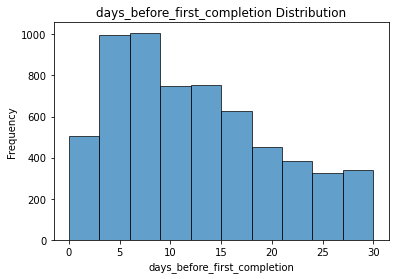

In [145]:
# Plot histogram for the 'days_before_first_completion' column
data['days_before_first_completion'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('days_before_first_completion')
plt.ylabel('Frequency')
plt.title('days_before_first_completion Distribution')

# Show the plot
plt.show()

In [146]:
data['days_before_bgc'].describe()

count    32896.000000
mean        10.046541
std         10.519617
min          0.000000
25%          2.000000
50%          6.000000
75%         15.000000
max         69.000000
Name: days_before_bgc, dtype: float64

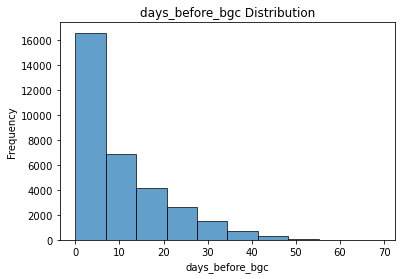

In [147]:
# Plot histogram for the 'days_before_bgc' column
data['days_before_bgc'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('days_before_bgc')
plt.ylabel('Frequency')
plt.title('days_before_bgc Distribution')

# Show the plot
plt.show()

In [148]:
data['days_before_vehicle_added'].describe()

count    13134.000000
mean        15.203213
std         14.064727
min         -5.000000
25%          4.000000
50%         11.000000
75%         24.000000
max         72.000000
Name: days_before_vehicle_added, dtype: float64

### plot histograms for numerical variables

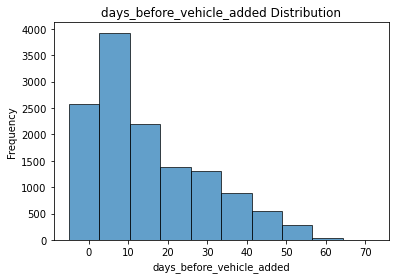

In [149]:
# Plot histogram for the 'days_before_vehicle_added' column
data['days_before_vehicle_added'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('days_before_vehicle_added')
plt.ylabel('Frequency')
plt.title('days_before_vehicle_added Distribution')

# Show the plot
plt.show()

In [150]:
data['completion_status'] = data['first_completed_date'].notnull().astype(int)
data['bgc_status'] = data['bgc_date'].notnull().astype(int)
data['vehicle_added_status'] = data['vehicle_added_date'].notnull().astype(int)

In [151]:
data.columns

Index(['id', 'city_name', 'signup_os', 'signup_channel', 'signup_date',
       'bgc_date', 'vehicle_added_date', 'vehicle_make', 'vehicle_model',
       'vehicle_year', 'first_completed_date', 'days_before_first_completion',
       'days_before_bgc', 'days_before_vehicle_added', 'completion_status',
       'bgc_status', 'vehicle_added_status'],
      dtype='object')

In [152]:
data.groupby('city_name')['completion_status'].sum().reset_index(name = 'the number of first_completion')

,city_name,the number of first_completion
0,Berton,2437
1,Strark,3239
2,Wrouver,461


## Build Predictive Models

### one-hot encoding

In [153]:
catgorical_data = data[['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model']]

# Encode categorical variables (e.g., 'city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model')
encoded_data = pd.get_dummies(catgorical_data, columns=['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model'])

combined_data = pd.concat([data[['bgc_status', 'vehicle_added_status']], encoded_data], axis=1)

In [154]:

combined_data.head()

,bgc_status,vehicle_added_status,city_name_Berton,city_name_Strark,city_name_Wrouver,signup_os_android web,signup_os_ios web,signup_os_mac,signup_os_other,signup_os_windows,...,vehicle_model_ZDX,vehicle_model_Zephyr,vehicle_model_e-Golf,vehicle_model_i3,vehicle_model_iA,vehicle_model_iM,vehicle_model_tC,vehicle_model_xA,vehicle_model_xB,vehicle_model_xD
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### selecting features

In [155]:
# Select the features and target variable
X = combined_data
y = data['completion_status']


### Split the data into training and testing sets

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Train a Logistic Regression model

In [157]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Predict on the test set

In [158]:

y_pred = model.predict(X_test)

### Evaluate the model

In [159]:
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
print("Confusion Matrix:\n", conf_matrix)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     14560
           1       0.53      0.40      0.46      1845

    accuracy                           0.89     16405
   macro avg       0.73      0.68      0.70     16405
weighted avg       0.88      0.89      0.89     16405

Confusion Matrix:
 [[13895   665]
 [ 1099   746]]


precision: among all the positive predictions, 53% of which are true. (among all the predicted drivers, only 53% of which indeed started driving.)
recall: among all the true postives, 40% of which are correctly identified by the model. (among all the first-completion drivers, 40% of which were captured by this model.)

### Get row-level probabilities

In [160]:
probabilities = model.predict_proba(X_train)

# The second column contains the probability for class 1 (starting to drive)
probability_of_class_1 = pd.DataFrame(probabilities[:, 1],columns=['probability_of_class_1'])

final_data = pd.concat([combined_data,probability_of_class_1], axis = 1)
final_data.head()

,bgc_status,vehicle_added_status,city_name_Berton,city_name_Strark,city_name_Wrouver,signup_os_android web,signup_os_ios web,signup_os_mac,signup_os_other,signup_os_windows,...,vehicle_model_Zephyr,vehicle_model_e-Golf,vehicle_model_i3,vehicle_model_iA,vehicle_model_iM,vehicle_model_tC,vehicle_model_xA,vehicle_model_xB,vehicle_model_xD,probability_of_class_1
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.470110
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.000120
2,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.009184
3,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000138
4,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000189


## Extracting business insigts from the model

In [161]:
final_data.groupby('bgc_status')['probability_of_class_1'].mean()

bgc_status
0    0.112723
1    0.111741
Name: probability_of_class_1, dtype: float64

In [162]:
final_data.groupby('vehicle_added_status')['probability_of_class_1'].mean()

vehicle_added_status
0    0.111325
1    0.114623
Name: probability_of_class_1, dtype: float64

In [163]:
data.groupby('city_name')['completion_status'].sum().reset_index(name = 'the number of first_completion')
# a lot of signups from city Strark had high success rate of completing the first driving experience

,city_name,the number of first_completion
0,Berton,2437
1,Strark,3239
2,Wrouver,461


In [164]:
data.columns

Index(['id', 'city_name', 'signup_os', 'signup_channel', 'signup_date',
       'bgc_date', 'vehicle_added_date', 'vehicle_make', 'vehicle_model',
       'vehicle_year', 'first_completed_date', 'days_before_first_completion',
       'days_before_bgc', 'days_before_vehicle_added', 'completion_status',
       'bgc_status', 'vehicle_added_status'],
      dtype='object')

In [165]:
data.groupby('vehicle_added_status')['completion_status'].sum().reset_index(name = 'the number of first_completion')


,vehicle_added_status,the number of first_completion
0,0,265
1,1,5872


In [166]:
5872/(5872+265)
# once a signup added vehicle, 96% of the chance they will start driving. 

0.9568192928140785

In [167]:
data.groupby('signup_channel')['completion_status'].sum().reset_index(name = 'the number of first_completion')
# most of the drivers came from referral program.

,signup_channel,the number of first_completion
0,Organic,1210
1,Paid,1482
2,Referral,3445


In [168]:
data.groupby('signup_os')['completion_status'].sum().reset_index(name = 'the number of first_completion')
# most of the signups used android web os

,signup_os,the number of first_completion
0,android web,1454
1,ios web,2191
2,mac,948
3,other,498
4,windows,898
